In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')

Mounted at /content/drive


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [3]:
import torch.nn as nn

# Backbone Block
class block(nn.Module):
    def __init__(self, input_channels, output_channels, r):
        super(block, self).__init__()
        
        # SpatialAvgeragePool
        # Use AdaptiveAvgPool2d to calculate spatial average of each channel
        # (1,1) is the output size, meaning that it will return an element per channel
        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        
        # In the block there are 4 convolutions layers 
        # The vector resulted from SpatialAveragePool is passed into MLP to predict a vector of 4 elements
        self.linear1 = nn.Linear(input_channels, output_channels//r)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(output_channels//r, 4)
        self.sigmoid = nn.Sigmoid()
        
        # Define the 4 convolution layers and Batch Normalisaton (BN) layers
        # Each convolution layer has different specification to capture details in different scales
        # Conv1 is just a 1x1 convolution
        # Conv2 has a 3x3 kernel with 1 padding to maintain same output size
        # Conv3 has a 5x5 kernel with 2 padding to maintain same output size
        # Conv4 is first applied a 3x3 Max Pooling with 1 padding, followed by a 1x1 convolution
        self.conv1 = nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(input_channels, output_channels, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(input_channels, output_channels, kernel_size=1)
        self.max = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(input_channels, output_channels, kernel_size=1)

        self.bn = nn.LazyBatchNorm2d()
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()
        self.bn3 = nn.LazyBatchNorm2d()
        self.bn4 = nn.LazyBatchNorm2d()
        
    def forward(self, x):
        a = self.avg_pool(x).flatten(1) # SpatialAveregePool, flatten it to pass into the MLP
        a = self.relu(self.linear1(a)) # First linear layer, activated by ReLU
        a = self.sigmoid(self.linear2(a))# Second linear layer, activated by Sigmoid
        
        a0 = torch.split(a, 1, dim=1)[0] # Extract a1,a2,a3,a4 from vector a, from (batch_size,4) to (batch_size,1)
        a0 = torch.unsqueeze(a0, dim=1) # Unsqueeze it to match the tensor dimension (batch_size,1,1,1)
        a0 = torch.unsqueeze(a0, dim=2)
        
        a1 = torch.split(a, 1, dim=1)[1]
        a1 = torch.unsqueeze(a1, dim=1)
        a1 = torch.unsqueeze(a1, dim=2)
        
        a2 = torch.split(a, 1, dim=1)[2]
        a2 = torch.unsqueeze(a2, dim=1)
        a2 = torch.unsqueeze(a2, dim=2)
        
        a3 = torch.split(a, 1, dim=1)[3]
        a3 = torch.unsqueeze(a3, dim=1)
        a3 = torch.unsqueeze(a3, dim=2)
        
        # Each convolution layer is activated by ReLU and followed by BN
        b1 = self.relu(self.bn1(self.conv1(x)))
        b2 = self.relu(self.bn2(self.conv2(x)))
        b3 = self.relu(self.bn3(self.conv3(x)))
        b4 = self.relu(self.bn4(self.conv4(self.max(x))))
        
        # Results from the 4 convolution layers are combined using vector a
        # Feature maps from each convolution are multiplied with an element of vector a and are added together
        # Output of the block = a1*conv1 + a2*conv2 +a3*conv3 + a4*conv4
        # The output is activated by ReLU
        out = b1*a0 + b2*a1 + b3*a2 + b4*a3
        out = self.bn(out)
        return out 

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # Construct a stem with a convolution layer activated by ReLU
        # the 3-channel RGB images will first turn into 16 output channels
        self.stem = nn.Sequential(nn.Conv2d(3,16,kernel_size=3, padding=1),
                                  nn.ReLU())
        
        # Construct the blocks by defining the input and output channels
        self.block1 = block(16,64,8)
        self.block2 = block(64,256,8)
        self.block3 = block(256,512,16)
        self.block4 = block(512,1024,16)
        self.block5 = block(1024,2048,32)

        # Define a 2x2 Max Pooling, stride 2 layer
        self.max_pool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.relu = nn.ReLU()

        # The Classifier
        # Again, use AdaptiveAvgPool2d to calculate spatial average of each channel
        # Flatten it and pass it to Softmax regression classifier
        self.classifier = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)), 
                                        nn.Flatten(),
                                        nn.Dropout(0.3),
                                        nn.Linear(2048, 10))
        
    def forward(self, x):
        out = x
        out = self.stem(out)
        out = self.block1(out)
        out = self.relu(out)
        out = self.block2(out)
        out = self.relu(out)
        out = self.max_pool(out) # Max Pooling is applied to reduce spatial dimension between blocks
        out = self.block3(out)
        out = self.relu(out)
        out = self.max_pool(out)
        out = self.block4(out)
        out = self.relu(out)
        out = self.max_pool(out)
        out = self.block5(out)

        out = self.classifier(out)
        return out

In [5]:
net = CNN()

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [6]:
# Initialize the weights
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)

In [7]:
net.apply(init_weights)

CNN(
  (stem): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (block1): block(
    (avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
    (linear1): Linear(in_features=16, out_features=8, bias=True)
    (relu): ReLU()
    (linear2): Linear(in_features=8, out_features=4, bias=True)
    (sigmoid): Sigmoid()
    (conv1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv3): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (max): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    (conv4): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_ru

In [8]:
# Define Image Augumentation on the training set to improve performance
# source: https://www.kaggle.com/code/vikasbhadoria/cifar10-high-accuracy-model-build-on-pytorch
transform_train = transforms.Compose([transforms.RandomCrop(size=32, padding=4),
                                      transforms.RandomHorizontalFlip(), # Randomly flip the image horizontally
                                      transforms.RandomRotation(10),     # Randomly rotate the image to a specified angel
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), # Performs actions like zooms, change shear angles.
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
                                      transforms.ToTensor(), # Convert the image to Tensors for processing
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize the values of all the images
                                      ])

# For the test set, only convert the images to Tensors and normalize the values
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [9]:
# Download the dataset and apply the transformation
# source: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html?highlight=cifar
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:03<00:00, 48453460.09it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [10]:
# Define the learning rate, number of epochs and batch size
lr, num_epochs, batch_size = 0.005, 60, 32

train_iter = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_iter = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [11]:
# Training script
# source: https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

def train_loop(train_iter, test_iter, net, num_epochs, loss, optimizer, device):
    # Create empty lists to store training results for plotting
    train_losses = []
    train_acc = []
    test_acc = []
    
    net.to(device) # Make sure the model is in the device
    
    for i in range(num_epochs):
        net.train() # set to training mode
        train_loss, train_correct = 0, 0
        print(f"Epoch {i+1}\n-------------------------------")
        train_size = len(train_iter.dataset) # number of training samples
        for batch, (X, y) in enumerate(train_iter):
            # Compute prediction and loss
            train_num_batches = len(train_iter) # number of batches in training set
            X, y = X.to(device), y.to(device) # Make sure the tensors are also in the same device
            pred = net(X)
            l = loss(pred, y)
            train_correct += (pred.argmax(1) == y).type(torch.float).sum().item() # sum of correct predictions
            train_loss += l.item() # total training loss in each epoch
            
            # Backpropagation
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            
            if batch % 200 == 199: # show update for every 100 batches
                # loss in this batch and number of samples trained in this epoch
                l, current = l.item(), (batch + 1) * len(X)
                print(f"loss: {l:>7f}  [{current:>5d}/{train_size:>5d}]")
                
        # For each epoch, 
        # the average training loss is the total loss of all batches divided by the number of batches;
        # the training accuracy is the total number of correct predictions divided by the numbers of training samples
        train_loss /= train_num_batches
        train_correct /= train_size
        
        # Append the values to the lists for plotting
        train_losses.append(train_loss)
        train_acc.append(train_correct)
        print(f"Train Accuracy: {train_correct:>3f}, Train Avg loss: {train_loss:>7f}")
        
        # For evaluation, first set it to evaluation mode
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
            
        size = len(test_iter.dataset) # number of test samples
        num_batches = len(test_iter) # number of batches in test set
        test_loss, test_correct = 0, 0

        with torch.no_grad():
            for X, y in test_iter:
                X, y = X.to(device), y.to(device)
                pred = net(X)
                test_loss += loss(pred, y).item() # calculate total test loss in each epoch
                test_correct += (pred.argmax(1) == y).type(torch.float).sum().item() # sum of correct predictions

        # Similarly, 
        # the average test loss is the total loss of all batches divided by the number of batches;
        # the test accuracy is the total number of correct predictions divided by the numbers of test samples
        test_loss /= num_batches
        test_correct /= size
        if i > 0:
            if test_correct > max(test_acc) and test_correct > 0.9:
                PATH = f'./cifar_{test_correct*10000:.0f}.pth'
                torch.save(net, PATH)
                print('Model saved!')
        test_acc.append(test_correct) # Append test accuracy to the lists for plotting
        print(f"Test Accuracy: {test_correct:>3f}, Test Avg loss: {test_loss:>8f} \n")
          
    
    # Plot the curves
    plt.figure(figsize=(10,5))
    plt.plot(train_losses, color='blue', linestyle='-', label="train loss")
    plt.plot(train_acc, color='red', linestyle=':', label="train acc")
    plt.plot(test_acc, color='green', linestyle='--', label="test acc")
    
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    print(f'Training finished. The highest validation accuracy is {max(test_acc)}.')

Using device: cuda
Tesla T4
Epoch 1
-------------------------------
loss: 1.827053  [ 6400/50000]
loss: 1.496648  [12800/50000]
loss: 1.702716  [19200/50000]
loss: 1.592972  [25600/50000]
loss: 1.245253  [32000/50000]
loss: 1.690328  [38400/50000]
loss: 1.085090  [44800/50000]
Train Accuracy: 0.448440, Train Avg loss: 1.542224
Test Accuracy: 0.584100, Test Avg loss: 1.188408 

Epoch 2
-------------------------------
loss: 1.044629  [ 6400/50000]
loss: 1.001892  [12800/50000]
loss: 1.503025  [19200/50000]
loss: 1.045212  [25600/50000]
loss: 1.157553  [32000/50000]
loss: 0.800478  [38400/50000]
loss: 1.059570  [44800/50000]
Train Accuracy: 0.623360, Train Avg loss: 1.071822
Test Accuracy: 0.704500, Test Avg loss: 0.828980 

Epoch 3
-------------------------------
loss: 0.860533  [ 6400/50000]
loss: 1.002791  [12800/50000]
loss: 1.127401  [19200/50000]
loss: 0.718570  [25600/50000]
loss: 0.607569  [32000/50000]
loss: 1.046333  [38400/50000]
loss: 0.859350  [44800/50000]
Train Accuracy: 0.

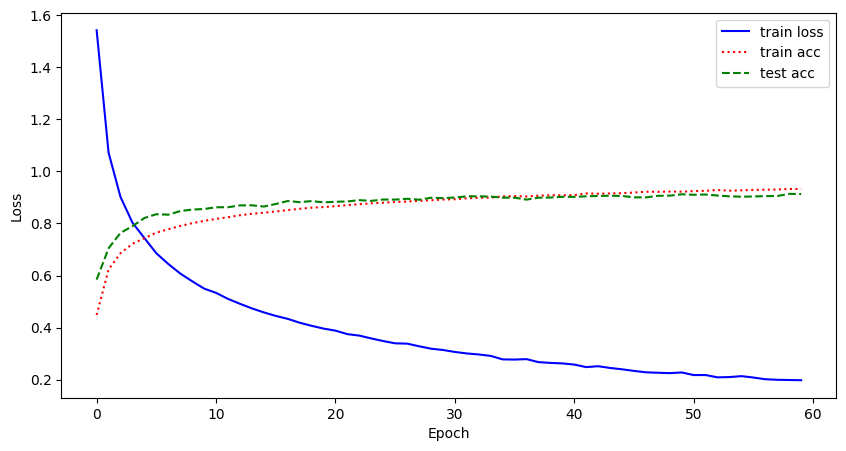

Training finished. The highest validation accuracy is 0.9137.


In [12]:
# Use GPU for training if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

# The following line is for training with Apple silicon
#device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) # print the type of the chosen gpu

train_loop(train_iter, test_iter, net, num_epochs, loss, optimizer, device)